<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v12c_ConvBackprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v12c - Aside: Convolution Backprop
It turns out that all the direct TF Support for calculating conv backprop w.r.t. to the filter was last in TF v1. In v2 it's much harder to compute.

For example, the following method appears to be from v1 that have been migrated but not clearly upgraded properly. I wasn't able to get it to work in initial tests. But there's no equivalent for 1d and 3d convolutions.
* `tf.conv2d_backprop_filter_v2`

Instead, I found mention online that it's possible to calculate both transposes and backprops via the basic conv operation:
* https://stackoverflow.com/questions/39373230/what-does-tensorflows-conv2d-transpose-operation-do/44350789#44350789
* https://gist.github.com/yxlao/ef50416011b9587835ac752aa3ce3530

Other useful docs:
* https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

Learnings:
* conv_transpose has sometimes been described as for calculating the backprop w.r.t the input.
* apparently all operations can be implemented via conv alone.


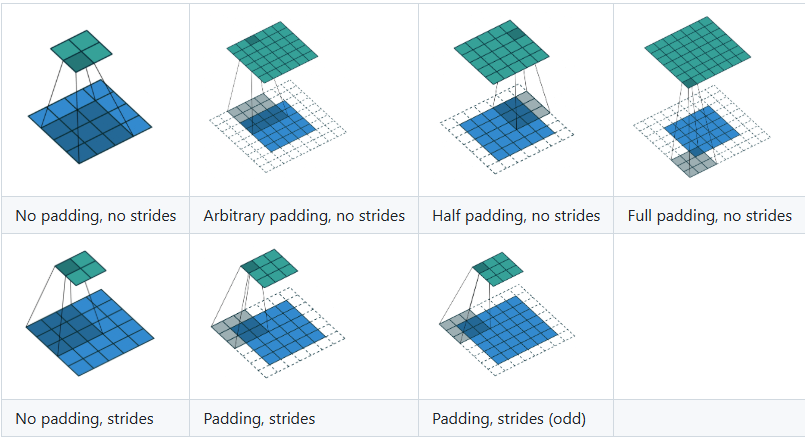

In [4]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
#!cd repo && git checkout 704ef35
!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
import train_explainer as te
import matmul_explainer as me
from importlib import reload
reload(tot)
reload(te)
reload(me)

HEAD is now at 26e004f Low-level experiments to calculate conv backprop via conv2d
Already up to date.


<module 'matmul_explainer' from '/content/repo/matmul_explainer.py'>

In [5]:
import train_observability_toolkit_test
import train_explainer_test
import matmul_explainer_test
reload(matmul_explainer_test)
reload(train_explainer_test)
reload(train_observability_toolkit_test)
reload(tot)
reload(me)
reload(te)
train_observability_toolkit_test.run_test_suite()
matmul_explainer_test.run_test_suite()
train_explainer_test.run_test_suite()

All train_observability_toolkit tests passed.
All matmul_explainer tests passed.
All train_explainer tests passed.


In [6]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import math

## Appendix: Experiments on general purpose method

In [74]:
def tf_pad_to_full_conv2d(x, w_size):
    """
    Pad x, such that using a 'VALID' convolution in tensorflow is the same
    as using a 'FULL' convolution. See
    http://deeplearning.net/software/theano/library/tensor/nnet/conv.html#theano.tensor.nnet.conv2d
    for description of 'FULL' convolution.
    """
    return tf.pad(x, [[0, 0],
                      [w_size - 1, w_size - 1],
                      [w_size - 1, w_size - 1],
                      [0, 0]])

def tf_NHWC_to_HWIO(out):
    """
    Converts [batch, in_height, in_width, in_channels]
    to       [filter_height, filter_width, in_channels, out_channels]
    """
    return tf.transpose(out, perm=[1, 2, 0, 3])

def tf_NHWC_to_CHWN(out):
    """
    Converts [batch, in_height, in_width, in_channels]
    to       [in_channels, in_height, in_width, batch]
    """
    return tf.transpose(out, perm=[3, 1, 2, 0])


def dilate(tensor, stride, extra_pad=None):
    """
    Inserts zeros between pixels in the spatial dimensions to simulate fractional strides.
    Args:
        tensor: A 4D tensor (NHWC) with shape (batch, height, width, channels)
        stride: Stride size (integer) - the number of zeros to insert between pixels.
    Returns:
        A new tensor with zeros interlaced along the spatial dimensions.
    """
    batch, height, width, channels = tensor.shape

    # Create empty tensor with expanded shape (height + gaps, width + gaps)
    new_height = height + (height - 1) * (stride - 1)
    new_width = width + (width - 1) * (stride - 1)

    # Create a tensor of zeros
    new_tensor = tf.zeros((batch, new_height, new_width, channels), dtype=tensor.dtype)

    # Assign original values to non-zero positions
    new_tensor = tf.tensor_scatter_nd_update(
        new_tensor,
        indices=tf.reshape(
            tf.stack(tf.meshgrid(
                tf.range(batch),
                tf.range(0, new_height, stride),
                tf.range(0, new_width, stride),
                indexing='ij'
            ), axis=-1),
            shape=(-1, 3)  # Flatten the indices
        ),
        updates=tf.reshape(tensor, [-1, channels])
    )
    if extra_pad is not None and (extra_pad[0] != 0 or extra_pad[1] != 0):
      orig_tensor = new_tensor
      l = max(extra_pad[0],0)
      r = max(extra_pad[1],0)
      l1 = l
      r1 = r
      new_tensor = tf.pad(new_tensor, [[0, 0],
                        [l, r],
                        [l, r],
                        [0, 0]])
      l = max(-extra_pad[0],0)
      r = max(-extra_pad[1],0)
      new_tensor = tf_crop(new_tensor, [[0, 0],
                        [l, r],
                        [l, r],
                        [0, 0]])
      print(f"  dilate: {orig_tensor.shape} -> pad: ({l1},{r1}), crop: ({l},{r}) -> {new_tensor.shape}")

    return new_tensor

def conv_backprop(x, d_out, strides, padding):
  # Basic pattern:
  #    input:   (  5, 120, 145, 32)  <-  (32, 120, 145,  5)  <- A_0
  #    filters: (118, 143,  32, 16)  <-  (32, 118, 143, 16)  <- dJdZ
  #    result:  (  5,   3,   3, 16)   -> ( 3,   3,   5, 16)   -> dJdW
  if padding == 'SAME':
    print(f"  pad(x, 2)")
    x_prepared = tf_NHWC_to_CHWN(tf_pad_to_full_conv2d(x, 2))
  else:
    x_prepared = tf_NHWC_to_CHWN(x)

  is_even = x.shape[1] % 2 == 0  # TODO handle per axis
  if strides[0] > 1:  # TODO handle per axis
    if not is_even:
      extra_padding = [0, 0]  # not needed for odd inputs
    elif padding == 'SAME':
      extra_padding = [1, 0]
    else:
      extra_padding = [0, 1]
    print(f"  dilate(d_out, 2, {extra_padding})")
    d_out_prepared = tf_NHWC_to_HWIO(dilate(d_out, 2, extra_padding))
  else:
    d_out_prepared = tf_NHWC_to_HWIO(d_out)

  print(f"  x:     {x_prepared.shape} <-  {x.shape}")
  print(f"  d_out: {d_out_prepared.shape} <-  {d_out.shape}")
  d_w_hwio = tf.nn.conv2d(
      input=x_prepared,
      filters=d_out_prepared,
      strides=[1, 1],
      padding='VALID')
  d_w = tf_NHWC_to_HWIO(d_w_hwio)
  print(f"  d_w:   {d_w_hwio.shape}  -> {d_w.shape}")
  return d_w

def test_conv_backprop(counters, A_0_shape, W_shape, strides, padding, description):
  tf.random.set_seed(36)
  A_0 = tf.random.normal(A_0_shape)
  W = tf.random.normal(W_shape)

  # forward pass plus ground-truth
  with tf.GradientTape() as tape:
    tape.watch(A_0)
    tape.watch(W)
    Z = tf.nn.conv2d(A_0, W, strides=strides, padding=padding)
    # simulate being part of a network by computing mse loss against an 'expected_Z'
    expected_Z = tf.random.normal(Z.shape)
    loss = tf.reduce_mean(tf.square(Z - expected_Z))
  dJdZ, true_dJdW = tape.gradient(loss, [Z, W])

  count = counters[0]
  counters[0] = count+1
  description = ("-- " + description) if description else ""
  print(f"[{count:2}] A_0: {A_0.shape}, W: {W.shape}, strides: {strides}, padding: {padding} -> Z: {expected_Z.shape} {description}")

  dJdW = conv_backprop(A_0, dJdZ, strides, padding)
  if dJdW.shape != true_dJdW.shape:
    print(f"  ==> ERROR: {dJdW.shape} != {true_dJdW.shape}")
  else:
    err = dJdW - true_dJdW
    rmse = tf.sqrt(tf.reduce_mean(tf.square(err)))
    if np.allclose(dJdW, true_dJdW):
      print(f"  ==> OK, rmse={rmse}")
    else:
      print(f"  ==> ERROR: rmse={rmse}: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}")
  print()

counters=[0]
test_conv_backprop(counters, A_0_shape=(32,  8,  8, 5), W_shape=(3, 3, 5, 16), strides=[1, 1], padding='VALID', description='Even A_0')
test_conv_backprop(counters, A_0_shape=(32,  8,  8, 5), W_shape=(3, 3, 5, 16), strides=[1, 1], padding='SAME', description='Even A_0')
test_conv_backprop(counters, A_0_shape=(32,  8,  8, 5), W_shape=(3, 3, 5, 16), strides=[2, 2], padding='VALID', description='Even A_0')
test_conv_backprop(counters, A_0_shape=(32,  8,  8, 5), W_shape=(3, 3, 5, 16), strides=[2, 2], padding='SAME', description='Even A_0')
test_conv_backprop(counters, A_0_shape=(32, 17, 17, 5), W_shape=(3, 3, 5, 16), strides=[1, 1], padding='VALID', description='Odd A_0')
test_conv_backprop(counters, A_0_shape=(32, 17, 17, 5), W_shape=(3, 3, 5, 16), strides=[1, 1], padding='SAME', description='Odd A_0')
test_conv_backprop(counters, A_0_shape=(32, 17, 17, 5), W_shape=(3, 3, 5, 16), strides=[2, 2], padding='VALID', description='Odd A_0')
test_conv_backprop(counters, A_0_shape=(32, 17, 17, 5), W_shape=(3, 3, 5, 16), strides=[2, 2], padding='SAME', description='Odd A_0')

test_conv_backprop(counters, A_0_shape=(32,  9,  9, 5), W_shape=(3, 3, 5, 16), strides=[2, 2], padding='VALID', description='Odd A_0')
test_conv_backprop(counters, A_0_shape=(32,  9,  9, 5), W_shape=(3, 3, 5, 16), strides=[2, 2], padding='SAME', description='Odd A_0')


[ 0] A_0: (32, 8, 8, 5), W: (3, 3, 5, 16), strides: [1, 1], padding: VALID -> Z: (32, 6, 6, 16) -- Even A_0
  x:     (5, 8, 8, 32) <-  (32, 8, 8, 5)
  d_out: (6, 6, 32, 16) <-  (32, 6, 6, 16)
  d_w:   (5, 3, 3, 16)  -> (3, 3, 5, 16)
  ==> OK, rmse=1.529284965329225e-08

[ 1] A_0: (32, 8, 8, 5), W: (3, 3, 5, 16), strides: [1, 1], padding: SAME -> Z: (32, 8, 8, 16) -- Even A_0
  pad(x, 2)
  x:     (5, 10, 10, 32) <-  (32, 8, 8, 5)
  d_out: (8, 8, 32, 16) <-  (32, 8, 8, 16)
  d_w:   (5, 3, 3, 16)  -> (3, 3, 5, 16)
  ==> OK, rmse=1.2401226712199787e-08

[ 2] A_0: (32, 8, 8, 5), W: (3, 3, 5, 16), strides: [2, 2], padding: VALID -> Z: (32, 3, 3, 16) -- Even A_0
  dilate(d_out, 2, [0, -1])
  dilate: (32, 5, 5, 16) -> pad: (0,0), crop: (0,1) -> (32, 4, 4, 16)
  x:     (5, 8, 8, 32) <-  (32, 8, 8, 5)
  d_out: (4, 4, 32, 16) <-  (32, 3, 3, 16)
  d_w:   (5, 5, 5, 16)  -> (5, 5, 5, 16)
  ==> ERROR: (5, 5, 5, 16) != (3, 3, 5, 16)

[ 3] A_0: (32, 8, 8, 5), W: (3, 3, 5, 16), strides: [2, 2], padding:

In [73]:
def tf_crop(tensor, crop_sizes):
    """
    Crops a tensor by removing elements from the start and end of each dimension.
    Args:
        tensor: Input tensor (any rank).
        crop_sizes: List of tuples [(crop_before_1, crop_after_1), (crop_before_2, crop_after_2), ...]
                    specifying how much to crop from each dimension.
    Returns:
        Cropped tensor.
    """
    tensor_shape = tf.shape(tensor)

    # Compute the start and new size for each dimension
    begin = [c[0] for c in crop_sizes]  # Start indices for cropping
    size = [tensor_shape[i] - (c[0] + c[1]) for i, c in enumerate(crop_sizes)]  # Compute new sizes

    return tf.slice(tensor, begin, size)

a = tf.random.uniform((32, 8, 8, 16))
tf_crop(a, [
    [0, 0],
    [1, 1],
    [1, 1],
    [0, 0]]
).shape

TensorShape([32, 6, 6, 16])

## Padding, cropping, and dilating

  dilate: (32, 15, 15, 16) -> pad: (0,1), crop: (0,0) -> (32, 16, 16, 16)
  dilate: (32, 15, 15, 16) -> pad: (1,0), crop: (0,0) -> (32, 16, 16, 16)


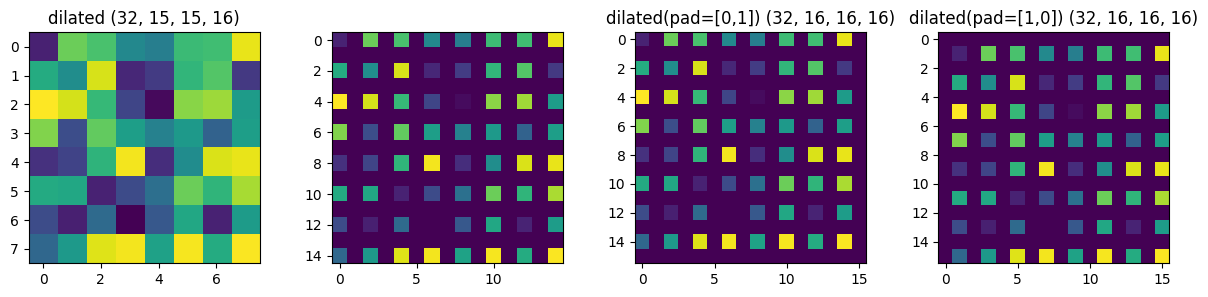

In [80]:
tf.random.set_seed(36)
x = tf.random.uniform((32, 8, 8, 16))
x2 = dilate(x, stride=2, extra_pad=[0, 0])
x3 = dilate(x, stride=2, extra_pad=[0, 1])
x4 = dilate(x, stride=2, extra_pad=[1, 0])

plt.figure(figsize=(15,3))

plt.subplot(1,4,1)
plt.title(f"original {x.shape}")
plt.imshow(x[0, :, :, 0])

plt.title(f"dilated {x2.shape}")
plt.subplot(1,4,2)
plt.imshow(x2[0, :, :, 0])

plt.subplot(1,4,3)
plt.title(f"dilated(pad=[0,1]) {x3.shape}")
plt.imshow(x3[0, :, :, 0])

plt.subplot(1,4,4)
plt.title(f"dilated(pad=[1,0]) {x4.shape}")
plt.imshow(x4[0, :, :, 0])

plt.show()

## Appendix: Initial manual experiments - via conv2d

In [19]:
# from: https://stackoverflow.com/questions/39373230/what-does-tensorflows-conv2d-transpose-operation-do/44350789#44350789
# and:  https://gist.github.com/yxlao/ef50416011b9587835ac752aa3ce3530
# also see: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md  <-- need to add this to my docs
def tf_rot180(w):
    """
    Roate by 180 degrees
    """
    return tf.reverse(w, axis=[0, 1])

def tf_pad_to_full_conv2d(x, w_size):
    """
    Pad x, such that using a 'VALID' convolution in tensorflow is the same
    as using a 'FULL' convolution. See
    http://deeplearning.net/software/theano/library/tensor/nnet/conv.html#theano.tensor.nnet.conv2d
    for description of 'FULL' convolution.
    """
    return tf.pad(x, [[0, 0],
                      [w_size - 1, w_size - 1],
                      [w_size - 1, w_size - 1],
                      [0, 0]])

def tf_NHWC_to_HWIO(out):
    """
    Converts [batch, in_height, in_width, in_channels]
    to       [filter_height, filter_width, in_channels, out_channels]
    """
    return tf.transpose(out, perm=[1, 2, 0, 3])

def tf_NHWC_to_CHWN(out):
    """
    Converts [batch, in_height, in_width, in_channels]
    to       [in_channels, in_height, in_width, batch]
    """
    return tf.transpose(out, perm=[3, 1, 2, 0])

#d_w_manual = tf_NHWC_to_HWIO(tf.nn.conv2d(input=x,
#                                          filter=tf_NHWC_to_HWIO(d_out),
#                                          strides=strides,
#                                          padding='VALID'))

A_0 = tf.random.normal((32, 8, 8, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
#dJdZ = tf.random.normal((32, 6, 6, 16))  # (batch=32, height=8, width=8, channels_out=16)
expected_Z = tf.random.normal((32, 6, 6, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=[1, 1], padding='VALID')
  # compute mse loss against expected_Z
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")


# Compute dJ/dW - original
# - error: input depth must be evenly divisible by filter depth: 5 vs 32
#dJdW = tf_NHWC_to_HWIO(tf.nn.conv2d(
#    input=A_0,
#    filters=tf_NHWC_to_HWIO(dJdZ),
#    strides=[1, 1],
#    padding='VALID'))

# - error: input depth must be evenly divisible by filter depth: 5 vs 6
#dJdW = tf.nn.conv2d(
#    input=A_0,
#    filters=dJdZ,
#    strides=[1, 1],
#    padding='VALID')

# prove that a normal looking conv2d_transpose works
# emulates dJdA_0 - backprop w.r.t. input
filters = tf.random.normal((3, 3, 5, 16))
fun = tf.nn.conv2d_transpose(
    input=dJdZ,                  # (32, 6, 6, 16),  where 6 = 8 - (3-1), 6 = 8 - (3-1)
    filters=filters,             # (3, 3, 5, 16)
    output_shape=(32, 8, 8, 5),  # (32, 8, 8, 5)
    strides=[1, 1],
    padding='VALID')             # out: (32, 8, 8, 5)
print(f"fun: {fun.shape}")

# emulating dJdA_0 - backprop w.r.t. input
#dJdW = tf.nn.conv2d_transpose(
#    input=tf.random.normal(  (32, 1, 2, 7)),
#    filters=tf.random.normal((3, 3, 5, 7)),
#    output_shape=            (32, 3, 4, 5),    # want (3, 3, 5, 7)
#    strides=[1, 1],
#    padding='VALID')
#print(f"dJdW: {dJdW.shape}")

# emulating dJdA_0 - backprop w.r.t. input (simple VALID padding, and 1x1 strides)
dJdW = tf.nn.conv2d(
    input=tf.random.normal(  (5, 16, 16, 32)),   # NHWC_to_CHWN(A_0)
    filters=tf.random.normal((14, 14, 32, 7)),   # NHWC_to_HWIO(dJdZ)
    strides=[1, 1],
    padding='VALID')
print(f"dJdW: {dJdW.shape}")  # (5, 3, 3, 7)

dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(A_0),       # (5, 8, 8, 32) <- (32, 8, 8, 5)
    filters=tf_NHWC_to_HWIO(dJdZ),    # (6, 6, 32, 16) <- (32, 6, 6, 16)
    strides=[1, 1],
    padding='VALID')                  # (5, 3, 3, 16)   -> (3, 3, 5, 16)
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")  # (5, 3, 3, 7)
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")

true: dJdZ: (32, 6, 6, 16), dJdW: (3, 3, 5, 16)
fun: (32, 8, 8, 5)
dJdW: (5, 3, 3, 7)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-8.9406967e-08 -7.4505806e-09  0.0000000e+00  7.4505806e-09
  5.9604645e-08], same: False


In [8]:
print(f"dJdZ: {dJdZ.shape}, padded: {tf_pad_to_full_conv2d(dJdZ, 2).shape}")

dJdZ: (32, 6, 6, 16), padded: (32, 8, 8, 16)


In [9]:
# for padding=SAME, pad A_0
padding='SAME'
strides=[1, 1]

A_0 = tf.random.normal((32, 8, 8, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
expected_Z = tf.random.normal((32, 8, 8, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=strides, padding=padding)
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")

dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(tf_pad_to_full_conv2d(A_0, 2)),
    filters=tf_NHWC_to_HWIO(dJdZ),
    strides=strides, padding='VALID')
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")  # (5, 3, 3, 7)
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")


true: dJdZ: (32, 8, 8, 16), dJdW: (3, 3, 5, 16)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-5.9604645e-08 -6.5192580e-09  0.0000000e+00  7.4505806e-09
  8.9406967e-08], same: True


In [10]:
# Padding VALID plus strides: dilate dJdZ with one-sided padding on RIGHT
padding='VALID'
strides=[2, 2]

def insert_zeros(tensor, stride, extra_pad=None):
    """
    Inserts zeros between pixels in the height and width dimensions to simulate fractional strides.

    Args:
        tensor: A 4D tensor (NHWC) with shape (batch, height, width, channels)
        stride: Stride size (integer) - the number of zeros to insert between pixels.

    Returns:
        A new tensor with zeros inserted in the height and width dimensions.
    """
    batch, height, width, channels = tensor.shape

    # Create empty tensor with expanded shape (height + gaps, width + gaps)
    new_height = height + (height - 1) * (stride - 1)
    new_width = width + (width - 1) * (stride - 1)

    # Create a tensor of zeros
    new_tensor = tf.zeros((batch, new_height, new_width, channels), dtype=tensor.dtype)

    # Assign original values to non-zero positions
    new_tensor = tf.tensor_scatter_nd_update(
        new_tensor,
        indices=tf.reshape(
            tf.stack(tf.meshgrid(
                tf.range(batch),
                tf.range(0, new_height, stride),
                tf.range(0, new_width, stride),
                indexing='ij'
            ), axis=-1),
            shape=(-1, 3)  # Flatten the indices
        ),
        updates=tf.reshape(tensor, [-1, channels])
    )
    if stride > 1 and extra_pad is not None:
      l = extra_pad[0]
      r = extra_pad[1]
      new_tensor = tf.pad(new_tensor, [[0, 0],
                        [l, r],
                        [l, r],
                        [0, 0]])

    return new_tensor


A_0 = tf.random.normal((32, 16, 16, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
expected_Z = tf.random.normal((32, 7, 7, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=strides, padding=padding)
  print(f"Z: {Z.shape}")
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")

print(f"dJdZ: {dJdZ.shape}, with strides: {insert_zeros(dJdZ, 2).shape}")

dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(tf_pad_to_full_conv2d(A_0, 1)),  # increase to make kernel bigger
    filters=tf_NHWC_to_HWIO(insert_zeros(dJdZ, 2, [0, 1])),
    strides=[1, 1], padding='VALID')
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")  # (5, 3, 3, 7)
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")


Z: (32, 7, 7, 16)
true: dJdZ: (32, 7, 7, 16), dJdW: (3, 3, 5, 16)
dJdZ: (32, 7, 7, 16), with strides: (32, 13, 13, 16)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-8.940697e-08 -7.450581e-09  0.000000e+00  7.450581e-09  8.940697e-08], same: True


In [11]:
# Padding SAME plus strides: pad A_0, dilate dJdZ with one-sided padding on LEFT
padding='SAME'
strides=[2, 2]

A_0 = tf.random.normal((32, 16, 16, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
expected_Z = tf.random.normal((32, 8, 8, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=strides, padding=padding)
  print(f"Z: {Z.shape}")
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")

print(f"dJdZ: {dJdZ.shape}, with strides: {insert_zeros(dJdZ, 2).shape}")

dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(tf_pad_to_full_conv2d(A_0, 2)),  # increase to make kernel bigger
    filters=tf_NHWC_to_HWIO(insert_zeros(dJdZ, 2, [1, 0])),
    strides=[1, 1], padding='VALID')
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")  # (5, 3, 3, 7)
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")


Z: (32, 8, 8, 16)
true: dJdZ: (32, 8, 8, 16), dJdW: (3, 3, 5, 16)
dJdZ: (32, 8, 8, 16), with strides: (32, 15, 15, 16)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-5.9604645e-08 -7.4505806e-09  0.0000000e+00  7.4505806e-09
  5.9604645e-08], same: True


In [12]:
# Odd-sized inputs, padding=VALID: do nothing extra (same as for even sized inputs)
padding='VALID'
strides=[1, 1]

A_0 = tf.random.normal((32, 9, 9, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
expected_Z = tf.random.normal((32, 7, 7, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=strides, padding=padding)
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")

dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(tf_pad_to_full_conv2d(A_0, 1)),
    filters=tf_NHWC_to_HWIO(dJdZ),
    strides=strides, padding='VALID')
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")  # (5, 3, 3, 7)
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")

true: dJdZ: (32, 7, 7, 16), dJdW: (3, 3, 5, 16)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-5.9604645e-08 -7.4505806e-09  0.0000000e+00  7.4505806e-09
  8.9406967e-08], same: True


In [13]:
# Odd-sized inputs, padding=SAME: pad A_0 and nothing extra (same as for even sized inputs)
padding='SAME'
strides=[1, 1]

A_0 = tf.random.normal((32, 9, 9, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
expected_Z = tf.random.normal((32, 9, 9, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=strides, padding=padding)
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")

dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(tf_pad_to_full_conv2d(A_0, 2)),
    filters=tf_NHWC_to_HWIO(dJdZ),
    strides=strides, padding='VALID')
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")  # (5, 3, 3, 7)
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")

true: dJdZ: (32, 9, 9, 16), dJdW: (3, 3, 5, 16)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-5.9604645e-08 -3.7252903e-09  0.0000000e+00  3.7252903e-09
  5.9604645e-08], same: True


In [14]:
# Odd-sized inputs, padding VALID plus strides: dilate dJdZ without one-sided padding
padding='VALID'
strides=[2, 2]

A_0 = tf.random.normal((32, 17, 17, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
expected_Z = tf.random.normal((32, 8, 8, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=strides, padding=padding)
  print(f"Z: {Z.shape}")
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")

print(f"dJdZ: {dJdZ.shape}, with strides: {insert_zeros(dJdZ, 2, [0, 0]).shape}")

dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(tf_pad_to_full_conv2d(A_0, 1)),  # increase to make kernel bigger
    filters=tf_NHWC_to_HWIO(insert_zeros(dJdZ, 2, [0, 0])),
    strides=[1, 1], padding='VALID')
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")  # (5, 3, 3, 7)
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")


Z: (32, 8, 8, 16)
true: dJdZ: (32, 8, 8, 16), dJdW: (3, 3, 5, 16)
dJdZ: (32, 8, 8, 16), with strides: (32, 15, 15, 16)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-5.9604645e-08 -7.4505806e-09  0.0000000e+00  7.4505806e-09
  5.9604645e-08], same: True


In [15]:
# Odd-sized inputs, padding SAME plus strides: pad A_0, dilate dJdZ without one-sided padding
padding='SAME'
strides=[2, 2]

A_0 = tf.random.normal((32, 17, 17, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
expected_Z = tf.random.normal((32, 9, 9, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=strides, padding=padding)
  print(f"Z: {Z.shape}")
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")

print(f"dJdZ: {dJdZ.shape}, with strides: {insert_zeros(dJdZ, 2).shape}")

dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(tf_pad_to_full_conv2d(A_0, 2)),  # increase to make kernel bigger
    filters=tf_NHWC_to_HWIO(insert_zeros(dJdZ, 2, [0, 0])),
    strides=[1, 1], padding='VALID')
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")  # (5, 3, 3, 7)
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")


Z: (32, 9, 9, 16)
true: dJdZ: (32, 9, 9, 16), dJdW: (3, 3, 5, 16)
dJdZ: (32, 9, 9, 16), with strides: (32, 17, 17, 16)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-4.4703484e-08 -3.7252903e-09  0.0000000e+00  3.7252903e-09
  2.9802322e-08], same: True


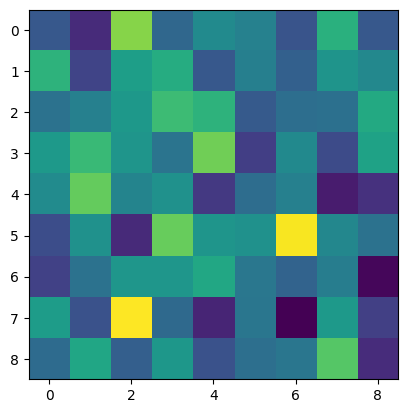

In [16]:
plt.imshow(dJdZ[0, :, :, 0])

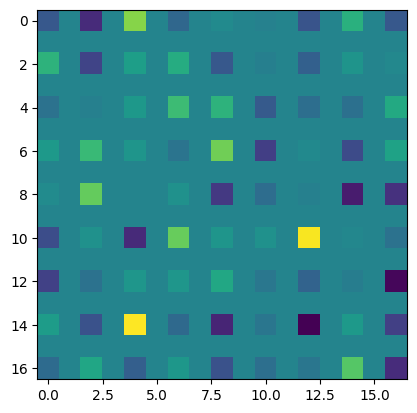

In [17]:
plt.imshow(insert_zeros(dJdZ, 2)[0, :, :, 0])

## Appendix: Initial manual experiments - via conv_transpose
The problem with conv2d for backprop is that to support strides in the original conv, you need to use "fractional striding" on the inverse. That's exactly what's implemented in conv_transpose().

Plus there's a generic any-dimensional version of it. So getting it to work would be great.

Unfortunately, it seems that conv_transpose really is only for calculating the backprop w.r.t. the inputs.

In [18]:
# Let's now try via conv_transpose
A_0 = tf.random.normal((32, 8, 8, 5))  # (batch=32, height=8, width=8, channels_in=5)
W_shape = (3, 3, 5, 16)  # (filter_height=3, filter_width=3, in_channels=5, out_channels=16)
W = tf.random.normal(W_shape)
#dJdZ = tf.random.normal((32, 6, 6, 16))  # (batch=32, height=8, width=8, channels_out=16)
expected_Z = tf.random.normal((32, 6, 6, 16))

with tf.GradientTape() as tape:
  tape.watch(A_0)
  tape.watch(W)
  Z = tf.nn.conv2d(A_0, W, strides=[1, 1], padding='VALID')
  # compute mse loss against expected_Z
  loss = tf.reduce_mean(tf.square(Z - expected_Z))
dJdZ, true_dJdW = tape.gradient(loss, [Z, W])
print(f"true: dJdZ: {dJdZ.shape}, dJdW: {true_dJdW.shape}")

# prove that a normal looking conv2d_transpose works
# emulates dJdA_0 - backprop w.r.t. input
fun = tf.nn.conv2d_transpose(
    input=tf.random.normal((5, 6, 6, 16)),
    filters=tf.random.normal((3, 3, 5, 16)),
    output_shape=(5, 8, 8, 5),  # want (5, 3, 3, 16) or (3, 3, 5, 16)
    strides=[1, 1],
    padding='VALID')
print(f"fun: {fun.shape}")
print()

fun = tf.nn.conv2d_transpose(
    input=tf.random.normal((5, 8, 9, 32)),
    filters=tf.random.normal((3, 4, 16, 32)),
    output_shape=(5, 10, 12, 16),  # want (5, 3, 3, 16) or (3, 3, 5, 16)
    strides=[1, 1],
    padding='VALID')
print(f"fun: {fun.shape}")
print()

# emulating dJdA_0 - backprop w.r.t. input (simple VALID padding, and 1x1 strides)
dJdW1 = tf.nn.conv2d(
    input=tf_NHWC_to_CHWN(A_0),       # (5, 8, 8, 32) <- (32, 8, 8, 5)
    filters=tf_NHWC_to_HWIO(dJdZ),    # (6, 6, 32, 16) <- (32, 6, 6, 16)
    strides=[1, 1],
    padding='VALID')                  # (5, 3, 3, 16)   -> (3, 3, 5, 16)
print(f"input={tf_NHWC_to_CHWN(A_0).shape}, filters={tf_NHWC_to_HWIO(dJdZ).shape}")
print(f"dJdW: {dJdW1.shape} -> {tf_NHWC_to_HWIO(dJdW1).shape}")
dJdW = tf_NHWC_to_HWIO(dJdW1)
err = dJdW - true_dJdW
print(f"err: {tfp.stats.percentile(err, [0, 25, 50, 75, 100])}, same: {np.allclose(dJdW, true_dJdW)}")

true: dJdZ: (32, 6, 6, 16), dJdW: (3, 3, 5, 16)
fun: (5, 8, 8, 5)

fun: (5, 10, 12, 16)

input=(5, 8, 8, 32), filters=(6, 6, 32, 16)
dJdW: (5, 3, 3, 16) -> (3, 3, 5, 16)
err: [-5.9604645e-08 -7.4505806e-09  0.0000000e+00  7.4505806e-09
  5.9604645e-08], same: False
